# Оценка результатов теста A/B

В текущем проекте необходимо провести анализ гипотез, приотеризировать гипотезы, затем провести А/В-тест и произвести анализ полученных результатов. Для выполнения работы предоставлено 3 датасета. Первый датасет с информацией по гипотезам, второй с информацией о заказах интернет-магазина, третий - о пользователях. Работу буду выполнять, придерживаясь следующего плана:
1. Ознакомление датасета с гипотезами, приоритезация гипотез с помощью фреймворков ICE и RICE.
2. Ознакомление и предобработка данных из второго и третьего датасетов.
3. Построение графиков и проведение анализа по ним:
	- график кумулятивной выручки по группам;
	-  график кумулятивного среднего чека по группам;
	-  график относительного изменения кумулятивного среднего чека группы B к группе A;
	-  график кумулятивного среднего количества заказов на посетителя по группам;
	-  график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A;
	-  точечный график количества заказов по пользователям.
4. Подсчет 95-й и 99-й перцентией количества заказов на пользователя. 
5. Построение точечного графика стоимостей заказов. 
9. Подсчет 95-й и 99-й перцентили стоимости заказов. 
10. Подсчет статистическрой значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 
11. Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным. 
12. Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 
13. Подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.
14. Принятие решения по результатам теста 


###  Загрузка данных и импорт библиотек

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [2]:
hypothesis= pd.read_csv('/datasets/hypothesis.csv')
orders= pd.read_csv('/datasets/orders.csv')
visitors= pd.read_csv('/datasets/visitors.csv')

In [3]:
# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)
# ознакомление с данными:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


В таблице нет пропусков, название столбцов все в едином реестре. Проверим на дубли и преведем данные с датой к корректному формату.

In [6]:
orders['date']=pd.to_datetime(orders['date'])
orders.duplicated().sum()

0

In [7]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [8]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


В таблице также нет пропусков, название столбцов  в едином реестре. Проверим на дубли и преведем данные с датой к корректному формату.

In [9]:
visitors['date']=pd.to_datetime(visitors['date'])
visitors.duplicated().sum()

0

Дубликатов в базах данных нет, можно приступать к следубщему этапу.

### Приоритезация гипотез

In [10]:
#фреймворк ICE:
hypothesis['ICE']=(hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts']
hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


8 гипотеза самая перспективная, затем идут 0 и 7. 

In [11]:
#фреймворк RICE:
hypothesis['RICE']=(hypothesis['Impact']*hypothesis['Confidence']*hypothesis['Reach'])/hypothesis['Efforts']
hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)


,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


При оценке гипотез методом RICE самыми эффективными оказались гипотезы номер 7, 2, 0 и 6. Разница этих методов в том, что при использовании метода RICE оцениваются не только насколько сильно повлияет изменение на пользователей и стоимость проверки гипотезы, но и то, какое количество пользователей это затрагивает.
В результате приоритезации самыми перспективными выглядят гипотезы 7, т.к. эти измения затронут абсолютно всех пользователей при сравнительно небольшой цене и 0, т.к. оказывает существенное влияние в связи с привлечением новых пользователей.

### Построение графиков и проведение анализа по ним

In [12]:
# проверим группы на совпадения пользователей
group_a = orders[orders['group'] == 'A']['visitorId']
group_b = orders[orders['group'] == 'B']['visitorId']
orders_ab = orders.query('visitorId in @group_a and visitorId in @group_b')
print('Всего пользователей в тесте:', orders['visitorId'].nunique())
print('Количество  совпадающих пользователей в двух группах:', orders_ab['visitorId'].nunique())

Всего пользователей в тесте: 1031
Количество  совпадающих пользователей в двух группах: 58


Около 5%  от общего числа пользователей пересекаются в 2 группах. Процента пересечения небольшой, поэтому оставим данные без изменений.

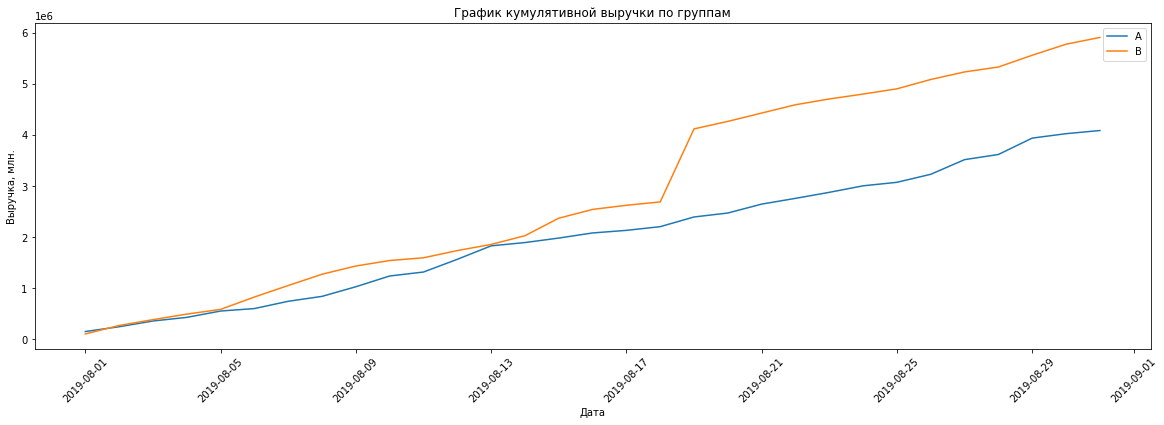

In [13]:
# график кумулятивной выручки по группам
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(
        orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {
            'date' : 'max',
            'group' : 'max',
            'transactionId' : 'nunique',
            'visitorId' : 'nunique',
            'revenue' : 'sum'
        }),
    axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(
        visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg(
        {
            'date' : 'max',
            'group' : 'max',
            'visitors' : 'sum'
        }), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(20, 6))
plt.xticks(rotation = 45)
plt.title('График кумулятивной выручки по группам')
plt.ylabel("Выручка, млн.")
plt.xlabel("Дата")
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend() 
plt.show()

Сегмент В по результатам превосходит сегмент А, но во второй половине теста происходит значительный отрыв, это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. 

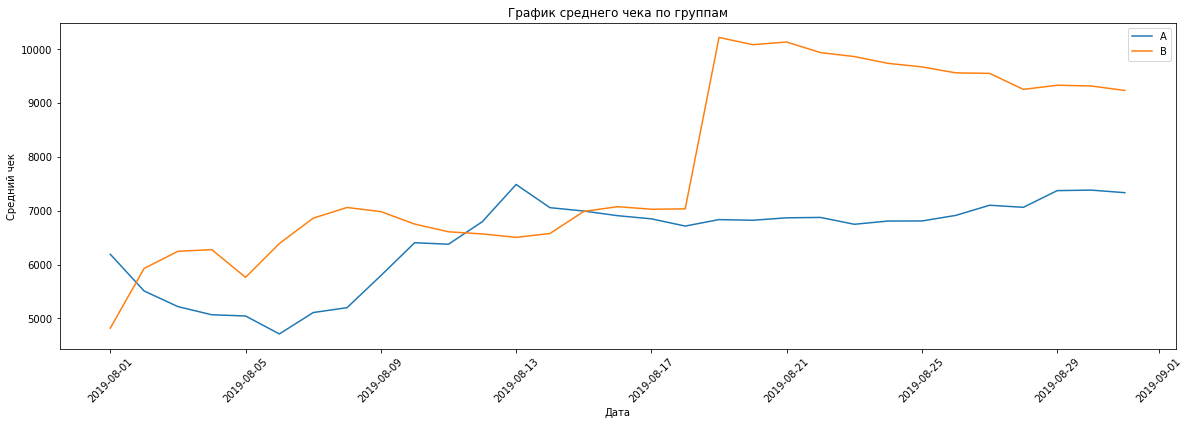

In [14]:
# график кумулятивного среднего чека по группам
plt.figure(figsize=(20, 6))
plt.xticks(rotation = 45)
plt.title('График среднего чека по группам')
plt.ylabel("Средний чек")
plt.xlabel("Дата")
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 

К середине теста кумулятивное значение среднего чека становится более равномерным, но все равно делать выводы по данным рано без дополнительного анализа выбросов. Резкий скачек среднего чека в группе В обусловлен аномально большим по сумме заказом.

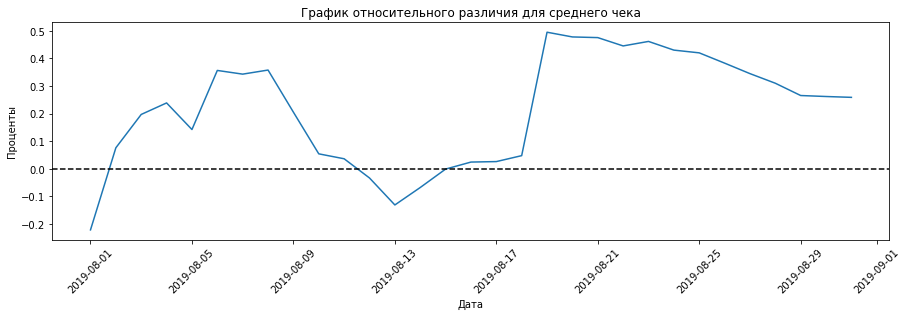

In [15]:
# график относительного изменения кумулятивного среднего чека группы B к группе A
plt.figure(figsize=(15, 4))
plt.xticks(rotation = 45)
plt.title('График относительного различия для среднего чека')
plt.ylabel("Проценты")
plt.xlabel("Дата")
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

Результаты теста сильно менялись несколько раз, видимо в эти даты были совершены аномальные заказы.

(18109.0, 18139.0, 0.01, 0.05)

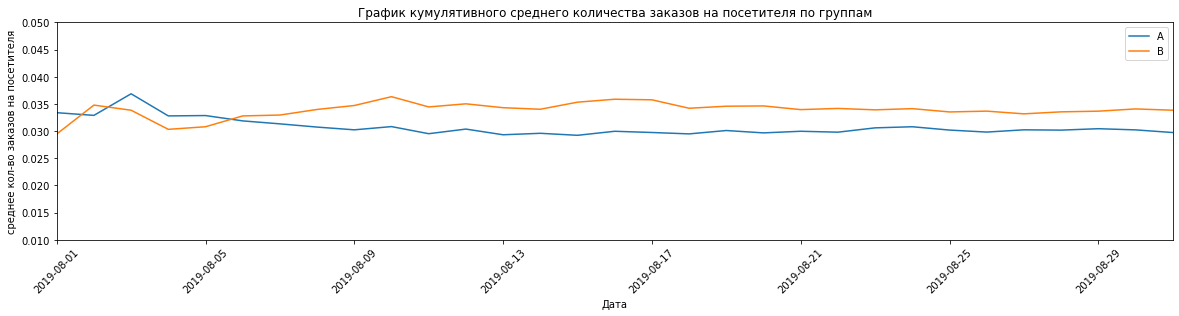

In [16]:
# график кумулятивного среднего количества заказов на посетителя по группам
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(20, 4))
plt.xticks(rotation = 45)
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.ylabel("среднее кол-во заказов на посетителя")
plt.xlabel("Дата")
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis(["2019-08-01", '2019-08-31', 0.010, 0.050])


В начале группы колебались около одного значения, но затем сегмент В вырвался вперед и данные выровнялись.

(18109.0, 18140.0, -0.2, 0.3)

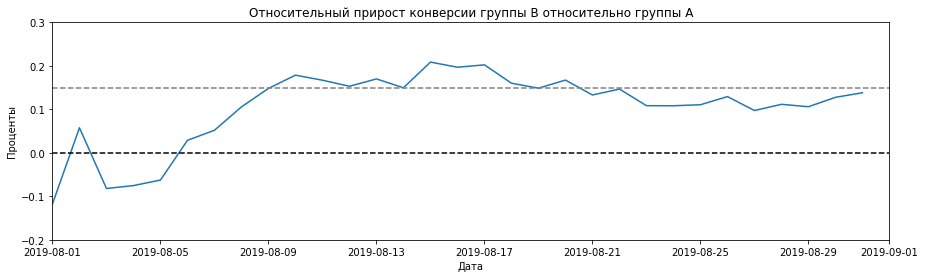

In [17]:
# график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15, 4))
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.ylabel("Проценты")
plt.xlabel("Дата")
plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.2, 0.3])



Прирост группы В по среднему числу заказов относительно группы А почти 15%. Но однозначно сказать, что показатели утановились по данному графику нельзя. По-прежнему сильно влияют выбросы.

По предыдущим графикам видно, что группа В показыввает лучшие результаты, но также на графиках присутствуют выбросы, поэтому далее проанализируем аномальные значения, такие как количество заказов на одного пользователя

### Оценка аномальных значений

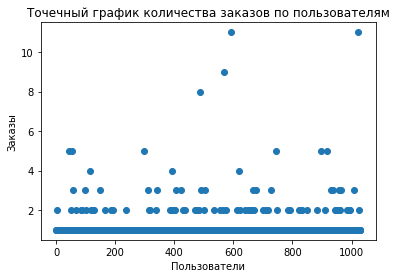

In [18]:
# точечный график количества заказов по пользователям
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.title('Точечный график количества заказов по пользователям')
plt.ylabel("Заказы")
plt.xlabel("Пользователи")
plt.scatter(x_values, ordersByUsers['orders']) 

В основном пользователи совершили не более двух заказов, но есть единичные пользователи, совершившие больше 6 заказов.

In [41]:
# подсчет 95-й и 99-й перцентией количества заказов на пользователя
np.percentile(ordersByUsers['orders'], [95, 99])


array([2., 4.])

Не более 5% пользователей совершили более 2 покупок и только 1% больше 4 покупок. Примем за верхнюю границу 4 заказа на одного пользователя для определения аномальных пользователей.

In [42]:
abd_orders = np.percentile(ordersByUsers['orders'], 99)

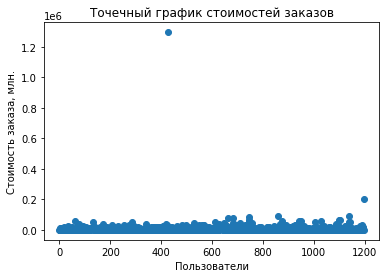

In [20]:
# построение точечного графика стоимостей заказов
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.title('Точечный график стоимостей заказов')
plt.ylabel("Стоимость заказа, млн.")
plt.xlabel("Пользователи")
plt.scatter(x_values, orders['revenue']) 

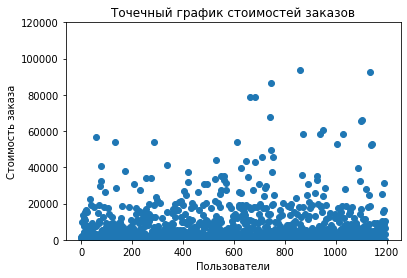

In [21]:
# построение укрупненного (без выбросов) точечного графика стоимостей заказов
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.title('Точечный график стоимостей заказов')
plt.ylabel("Стоимость заказа")
plt.xlabel("Пользователи")
plt.ylim(0, 120000)
plt.scatter(x_values, orders['revenue']) 

Есть единичные заказы дороже 200 тысяч рублей.

In [40]:
# подсчет 95-й и 99-й перцентили стоимости заказов
np.percentile(orders['revenue'], [95, 99]) 



array([28000. , 58233.2])

При этом 95% всех заказов не превышает 28000 рублей и лишь 1% заказов дороже 58000. Определим значение 99-ого перцентиля как границу стоимости аномальных заказов.


In [ ]:
abd_revenue = np.percentile(orders['revenue'], 99)

### Анализ статистической значимости

Мы уже оценили результаты A/B-теста визуально и выяснили, что в данных есть выбросы, увидели выбросы  их визуально на графиках и нашли границы для их определения.
Теперь посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.
Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.
Установим стандартный уровень статистической значимости, равный 0.05.
Для проверки гипотез будем использовать непараметрический тест Уилкоксона-Манна-Уитни.

#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным 

In [23]:
visitorsPerDateA=visitors[visitors['group']== 'A']
visitorsPerDateB=visitors[visitors['group']== 'B']

In [32]:
# создадим переменные ordersByUsersA и ordersByUsersB, 
# в них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

# для подготовки выборки к проверке критерием Манна-Уитни объявим переменные sampleA и sampleB, 
# в которых пользователям из разных групп будет соответствовать количество заказов. 
# Тем, кто ничего не заказал, будут соответствовать нули. 
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(
    0, index=np.arange(visitorsPerDateA['visitors'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(
    0, index=np.arange(visitorsPerDateB['visitors'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [25]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsPerDateA['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsPerDateB['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [44]:
# Функция для проверки гипотезы о равенстве групп data A и data B
def stat_significance(data_a, data_b):
    alpha = 0.05
    p_value = stats.mannwhitneyu(data_a, data_b)[1]
    print("P-value: {0:.3f}".format(p_value))

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между группами наблюдается статистически значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
    
    print("Относительный прирост В к А: {0:.3%}".format(data_b.mean() / data_a.mean()-1))
    
 
stat_significance(sampleA, sampleB)   

P-value: 0.017
Отвергаем нулевую гипотезу: между группами наблюдается статистически значимая разница
Относительный прирост В к А: 13.808%


#### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным
Нулевая гипотеза: различий в среднем чеке заказа между группами нет.
Альтернативная гипотеза: различия в среднем чеке заказа между группами есть.

In [27]:
stat_significance(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

P-value: 0.729
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: 25.871%


####  Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Нулевая гипотеза: различий в среднем количестве заказов между группами нет. Альтернативная гипотеза: различия есть.

In [43]:
# исключаем аномальные данные
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > abd_orders]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > abd_orders]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > abd_revenue]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
#print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])


15


Исключили аномальных пользователей.

In [29]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsPerDateA['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsPerDateB['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [45]:
stat_significance(sampleAFiltered, sampleBFiltered)

P-value: 0.014
Отвергаем нулевую гипотезу: между группами наблюдается статистически значимая разница
Относительный прирост В к А: 15.331%


Разница между "сырыми" и "очищенными данными всего 2 процентных пункта.

#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Нулевая гипотеза: различий в среднем чеке заказа между группами нет. Альтернативная гипотеза: различия в среднем чеке заказа между группами есть.

In [31]:
stat_significance(
    orders[(orders['group']=='A') & np.logical_not(orders['visitorId'].isin(abnormalUsers))]['revenue'], 
    orders[(orders['group']=='B') & np.logical_not(orders['visitorId'].isin(abnormalUsers))]['revenue'])
                  

P-value: 0.851
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: -0.575%


### Вывод

В результета исследования данных, предоставленных интернет-магазином можно сделать следующие выводы и рекомендации. 
Следуетпринять следующие гипотезы в разработку в первую очередь:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

Можно сделать вывод, что группы равны по среднему чеку и группа В превосходит группу А по среднему числу заказов, на основании этого тест нужно завершать, потому что тенденций к улучшению среднего чека в группе В по очищенным данным не наблюдается, статистически значимой разницы между группами нет, вероятность того, что что-то изменится в случае продолжения теста крайне мала. Тест можно признать успешным  по отношению среднему числу заказов группы В к группе А. 
То есть, изменения, проеверяемые в группе В имеют большее положительное влияние на выручку, т.к. при сохранении среднего чека заказа пользователи чаще совершают заказы.